<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:07] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


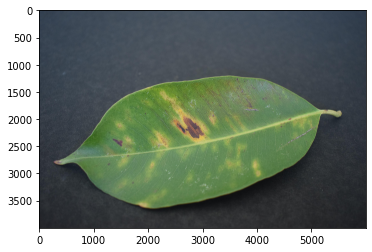

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

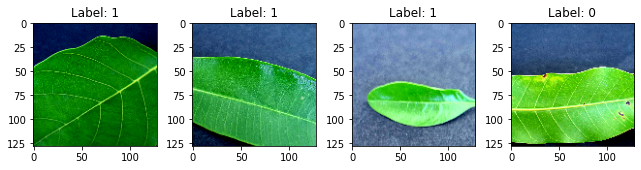

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:10:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2391475170726804 samples/sec                   batch loss = 0.6945539712905884 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.264467269094118 samples/sec                   batch loss = 1.3032433986663818 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.258409868050557 samples/sec                   batch loss = 0.4714529812335968 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2662002030181019 samples/sec                   batch loss = 0.6912498474121094 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2652509341823837 samples/sec                   batch loss = 0.5381752848625183 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.266470987830878 samples/sec                   batch loss = 0.6102252006530762 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.265824947046087 samples/sec                   batch loss = 1.0211552381515503 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2582655628391572 samples/sec                   batch loss = 0.21812503039836884 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.258794340097737 samples/sec                   batch loss = 1.2713369131088257 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.25939247575042 samples/sec                   batch loss = 2.271836519241333 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.27266792503182 samples/sec                   batch loss = 0.43473130464553833 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.26189520425072 samples/sec                   batch loss = 1.1016452312469482 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2610160665674424 samples/sec                   batch loss = 0.3468477427959442 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2580846853988918 samples/sec                   batch loss = 0.38063862919807434 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.2645467547272915 samples/sec                   batch loss = 0.5135208964347839 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.265087407690037 samples/sec                   batch loss = 0.9841176271438599 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.264223632607191 samples/sec                   batch loss = 0.36822274327278137 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2593950282573918 samples/sec                   batch loss = 0.5232346653938293 | accuracy = 0.6388888888888888


Epoch[1] Batch[95] Speed: 1.2615322656202181 samples/sec                   batch loss = 0.3465713560581207 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2690067565022427 samples/sec                   batch loss = 0.32184916734695435 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2653792853357726 samples/sec                   batch loss = 0.7412058711051941 | accuracy = 0.6619047619047619


Epoch[1] Batch[110] Speed: 1.2642524029302968 samples/sec                   batch loss = 0.9332445859909058 | accuracy = 0.6636363636363637


Epoch[1] Batch[115] Speed: 1.2575117313533206 samples/sec                   batch loss = 0.9397565722465515 | accuracy = 0.658695652173913


Epoch[1] Batch[120] Speed: 1.267803082799163 samples/sec                   batch loss = 0.8662863969802856 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.2636777210618553 samples/sec                   batch loss = 0.17431481182575226 | accuracy = 0.672


Epoch[1] Batch[130] Speed: 1.2660803797120646 samples/sec                   batch loss = 0.4707508385181427 | accuracy = 0.6730769230769231


Epoch[1] Batch[135] Speed: 1.2653306138037745 samples/sec                   batch loss = 0.2915392816066742 | accuracy = 0.674074074074074


Epoch[1] Batch[140] Speed: 1.2617070194136586 samples/sec                   batch loss = 0.5371527075767517 | accuracy = 0.6696428571428571


Epoch[1] Batch[145] Speed: 1.2677846886951212 samples/sec                   batch loss = 0.27347132563591003 | accuracy = 0.6689655172413793


Epoch[1] Batch[150] Speed: 1.2691784987272445 samples/sec                   batch loss = 0.7742292881011963 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2665526378825644 samples/sec                   batch loss = 0.33938559889793396 | accuracy = 0.6661290322580645


Epoch[1] Batch[160] Speed: 1.2672482372658185 samples/sec                   batch loss = 0.7397887110710144 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.2694189583241433 samples/sec                   batch loss = 0.8183425664901733 | accuracy = 0.6606060606060606


Epoch[1] Batch[170] Speed: 1.2683425930902867 samples/sec                   batch loss = 0.537617027759552 | accuracy = 0.663235294117647


Epoch[1] Batch[175] Speed: 1.2742059365824698 samples/sec                   batch loss = 0.35110336542129517 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.2801487477525961 samples/sec                   batch loss = 0.7976514101028442 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.2695753443575681 samples/sec                   batch loss = 0.3019007444381714 | accuracy = 0.6675675675675675


Epoch[1] Batch[190] Speed: 1.2688959023365853 samples/sec                   batch loss = 0.638268232345581 | accuracy = 0.6671052631578948


Epoch[1] Batch[195] Speed: 1.2691903083131235 samples/sec                   batch loss = 0.3820377290248871 | accuracy = 0.6705128205128205


Epoch[1] Batch[200] Speed: 1.2708177137452727 samples/sec                   batch loss = 0.43298712372779846 | accuracy = 0.6725


Epoch[1] Batch[205] Speed: 1.276435733958216 samples/sec                   batch loss = 0.6725798845291138 | accuracy = 0.6719512195121952


Epoch[1] Batch[210] Speed: 1.2661335043123603 samples/sec                   batch loss = 0.41202932596206665 | accuracy = 0.6738095238095239


Epoch[1] Batch[215] Speed: 1.2646502725818802 samples/sec                   batch loss = 0.5276291370391846 | accuracy = 0.6744186046511628


Epoch[1] Batch[220] Speed: 1.2718771693444326 samples/sec                   batch loss = 0.31405889987945557 | accuracy = 0.6761363636363636


Epoch[1] Batch[225] Speed: 1.2686734846118324 samples/sec                   batch loss = 0.45232677459716797 | accuracy = 0.6744444444444444


Epoch[1] Batch[230] Speed: 1.2652226908814266 samples/sec                   batch loss = 0.338129460811615 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.2611563580720861 samples/sec                   batch loss = 0.4816141128540039 | accuracy = 0.6734042553191489


Epoch[1] Batch[240] Speed: 1.264494811545442 samples/sec                   batch loss = 0.6461411118507385 | accuracy = 0.6697916666666667


Epoch[1] Batch[245] Speed: 1.265755327522517 samples/sec                   batch loss = 0.8677883744239807 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2674934240700981 samples/sec                   batch loss = 0.46609821915626526 | accuracy = 0.667


Epoch[1] Batch[255] Speed: 1.268017720124876 samples/sec                   batch loss = 0.4643864333629608 | accuracy = 0.6676470588235294


Epoch[1] Batch[260] Speed: 1.2684456784566005 samples/sec                   batch loss = 0.6891326904296875 | accuracy = 0.6673076923076923


Epoch[1] Batch[265] Speed: 1.2604267094631758 samples/sec                   batch loss = 0.6521704196929932 | accuracy = 0.6650943396226415


Epoch[1] Batch[270] Speed: 1.270062328166799 samples/sec                   batch loss = 0.6679680347442627 | accuracy = 0.6648148148148149


Epoch[1] Batch[275] Speed: 1.2683187180325732 samples/sec                   batch loss = 0.49665164947509766 | accuracy = 0.6663636363636364


Epoch[1] Batch[280] Speed: 1.2707286793264263 samples/sec                   batch loss = 0.7229586839675903 | accuracy = 0.66875


Epoch[1] Batch[285] Speed: 1.2639385723365928 samples/sec                   batch loss = 0.6191248893737793 | accuracy = 0.6719298245614035


Epoch[1] Batch[290] Speed: 1.2670664907181042 samples/sec                   batch loss = 0.45733508467674255 | accuracy = 0.6698275862068965


Epoch[1] Batch[295] Speed: 1.271934542270942 samples/sec                   batch loss = 0.3119276463985443 | accuracy = 0.6703389830508475


Epoch[1] Batch[300] Speed: 1.2694181899375332 samples/sec                   batch loss = 0.5440194606781006 | accuracy = 0.67


Epoch[1] Batch[305] Speed: 1.2634882430155838 samples/sec                   batch loss = 1.153153657913208 | accuracy = 0.6729508196721311


Epoch[1] Batch[310] Speed: 1.2669619072043343 samples/sec                   batch loss = 0.7347990274429321 | accuracy = 0.6758064516129032


Epoch[1] Batch[315] Speed: 1.2637694827364774 samples/sec                   batch loss = 0.39089182019233704 | accuracy = 0.6785714285714286


Epoch[1] Batch[320] Speed: 1.2713615275359478 samples/sec                   batch loss = 0.5382553339004517 | accuracy = 0.67890625


Epoch[1] Batch[325] Speed: 1.2707649653617425 samples/sec                   batch loss = 0.5106400847434998 | accuracy = 0.6792307692307692


Epoch[1] Batch[330] Speed: 1.2755219712046089 samples/sec                   batch loss = 0.5257701277732849 | accuracy = 0.6795454545454546


Epoch[1] Batch[335] Speed: 1.2661370397407354 samples/sec                   batch loss = 0.4585757851600647 | accuracy = 0.6798507462686567


Epoch[1] Batch[340] Speed: 1.267439132051451 samples/sec                   batch loss = 0.6953626871109009 | accuracy = 0.6816176470588236


Epoch[1] Batch[345] Speed: 1.264733976203225 samples/sec                   batch loss = 0.6466296315193176 | accuracy = 0.6826086956521739


Epoch[1] Batch[350] Speed: 1.2669969259275873 samples/sec                   batch loss = 0.1731690913438797 | accuracy = 0.6835714285714286


Epoch[1] Batch[355] Speed: 1.2696093547747769 samples/sec                   batch loss = 0.9475884437561035 | accuracy = 0.6823943661971831


Epoch[1] Batch[360] Speed: 1.2608408408273 samples/sec                   batch loss = 0.5294495820999146 | accuracy = 0.6826388888888889


Epoch[1] Batch[365] Speed: 1.2628762300125895 samples/sec                   batch loss = 0.5539939999580383 | accuracy = 0.6828767123287671


Epoch[1] Batch[370] Speed: 1.2691214701618838 samples/sec                   batch loss = 0.5555554032325745 | accuracy = 0.6837837837837838


Epoch[1] Batch[375] Speed: 1.262766064101356 samples/sec                   batch loss = 1.4365708827972412 | accuracy = 0.6806666666666666


Epoch[1] Batch[380] Speed: 1.2685070581676 samples/sec                   batch loss = 0.8735661506652832 | accuracy = 0.6815789473684211


Epoch[1] Batch[385] Speed: 1.2658079473336514 samples/sec                   batch loss = 0.5406532287597656 | accuracy = 0.6798701298701298


Epoch[1] Batch[390] Speed: 1.2610901896759859 samples/sec                   batch loss = 0.35415393114089966 | accuracy = 0.6820512820512821


Epoch[1] Batch[395] Speed: 1.2717184806127395 samples/sec                   batch loss = 0.23984861373901367 | accuracy = 0.6816455696202531


Epoch[1] Batch[400] Speed: 1.2662429206369428 samples/sec                   batch loss = 0.48227593302726746 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2723516398844532 samples/sec                   batch loss = 0.3627200424671173 | accuracy = 0.682716049382716


Epoch[1] Batch[410] Speed: 1.2668164949661738 samples/sec                   batch loss = 0.9148234128952026 | accuracy = 0.6817073170731708


Epoch[1] Batch[415] Speed: 1.2629056995629908 samples/sec                   batch loss = 0.8988764882087708 | accuracy = 0.6801204819277108


Epoch[1] Batch[420] Speed: 1.266289272991606 samples/sec                   batch loss = 0.7038773894309998 | accuracy = 0.680952380952381


Epoch[1] Batch[425] Speed: 1.264465934888191 samples/sec                   batch loss = 0.37298494577407837 | accuracy = 0.6823529411764706


Epoch[1] Batch[430] Speed: 1.2664158274200217 samples/sec                   batch loss = 0.38954654335975647 | accuracy = 0.6837209302325581


Epoch[1] Batch[435] Speed: 1.260327763633255 samples/sec                   batch loss = 0.43905872106552124 | accuracy = 0.6844827586206896


Epoch[1] Batch[440] Speed: 1.2608928632894683 samples/sec                   batch loss = 0.636182427406311 | accuracy = 0.6846590909090909


Epoch[1] Batch[445] Speed: 1.269014435430106 samples/sec                   batch loss = 0.1967746466398239 | accuracy = 0.6848314606741573


Epoch[1] Batch[450] Speed: 1.2709038724382549 samples/sec                   batch loss = 0.7251597046852112 | accuracy = 0.6855555555555556


Epoch[1] Batch[455] Speed: 1.2723073512816074 samples/sec                   batch loss = 0.538018524646759 | accuracy = 0.6868131868131868


Epoch[1] Batch[460] Speed: 1.261987751422078 samples/sec                   batch loss = 0.6049124002456665 | accuracy = 0.6853260869565218


Epoch[1] Batch[465] Speed: 1.273455314871189 samples/sec                   batch loss = 0.36644113063812256 | accuracy = 0.6844086021505377


Epoch[1] Batch[470] Speed: 1.2687185759499822 samples/sec                   batch loss = 0.7597321271896362 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.2679769909389598 samples/sec                   batch loss = 0.2739019989967346 | accuracy = 0.6831578947368421


Epoch[1] Batch[480] Speed: 1.2737112257405245 samples/sec                   batch loss = 0.7233549356460571 | accuracy = 0.6833333333333333


Epoch[1] Batch[485] Speed: 1.2708876024719002 samples/sec                   batch loss = 0.41682079434394836 | accuracy = 0.6845360824742268


Epoch[1] Batch[490] Speed: 1.2731669462584307 samples/sec                   batch loss = 0.46819743514060974 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2682852561110234 samples/sec                   batch loss = 0.6395829916000366 | accuracy = 0.6818181818181818


Epoch[1] Batch[500] Speed: 1.2678391061324172 samples/sec                   batch loss = 0.29804110527038574 | accuracy = 0.684


Epoch[1] Batch[505] Speed: 1.2630190275503534 samples/sec                   batch loss = 0.2578229308128357 | accuracy = 0.6856435643564357


Epoch[1] Batch[510] Speed: 1.2613296801329563 samples/sec                   batch loss = 0.9633098840713501 | accuracy = 0.6867647058823529


Epoch[1] Batch[515] Speed: 1.273144435037194 samples/sec                   batch loss = 0.414475679397583 | accuracy = 0.6878640776699029


Epoch[1] Batch[520] Speed: 1.272044481329915 samples/sec                   batch loss = 0.5784943103790283 | accuracy = 0.6870192307692308


Epoch[1] Batch[525] Speed: 1.2644094243224113 samples/sec                   batch loss = 0.4059118330478668 | accuracy = 0.6885714285714286


Epoch[1] Batch[530] Speed: 1.2657302128937298 samples/sec                   batch loss = 1.0481765270233154 | accuracy = 0.6872641509433962


Epoch[1] Batch[535] Speed: 1.262668271128574 samples/sec                   batch loss = 0.33425724506378174 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.2661419129311295 samples/sec                   batch loss = 0.13590531051158905 | accuracy = 0.6856481481481481


Epoch[1] Batch[545] Speed: 1.2683101845954572 samples/sec                   batch loss = 0.2535853087902069 | accuracy = 0.6862385321100918


Epoch[1] Batch[550] Speed: 1.272216660932653 samples/sec                   batch loss = 0.4981488883495331 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2757717285415973 samples/sec                   batch loss = 0.4228985905647278 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.2619643048548181 samples/sec                   batch loss = 0.6609341502189636 | accuracy = 0.6852678571428571


Epoch[1] Batch[565] Speed: 1.2690858539104846 samples/sec                   batch loss = 0.6235202550888062 | accuracy = 0.6849557522123894


Epoch[1] Batch[570] Speed: 1.2686110336056233 samples/sec                   batch loss = 1.2244516611099243 | accuracy = 0.6846491228070175


Epoch[1] Batch[575] Speed: 1.2681059916461939 samples/sec                   batch loss = 0.6426213383674622 | accuracy = 0.6830434782608695


Epoch[1] Batch[580] Speed: 1.264932792875633 samples/sec                   batch loss = 0.40989282727241516 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.2666956942640497 samples/sec                   batch loss = 0.35372209548950195 | accuracy = 0.6841880341880342


Epoch[1] Batch[590] Speed: 1.2713266524817224 samples/sec                   batch loss = 0.587807297706604 | accuracy = 0.6855932203389831


Epoch[1] Batch[595] Speed: 1.272471012540015 samples/sec                   batch loss = 0.17899549007415771 | accuracy = 0.6857142857142857


Epoch[1] Batch[600] Speed: 1.2715295711892405 samples/sec                   batch loss = 0.8276214599609375 | accuracy = 0.685


Epoch[1] Batch[605] Speed: 1.2736165644390671 samples/sec                   batch loss = 0.3433436155319214 | accuracy = 0.6847107438016529


Epoch[1] Batch[610] Speed: 1.2697250422624473 samples/sec                   batch loss = 0.3743756115436554 | accuracy = 0.6856557377049181


Epoch[1] Batch[615] Speed: 1.2659447220058306 samples/sec                   batch loss = 0.32652831077575684 | accuracy = 0.6849593495934959


Epoch[1] Batch[620] Speed: 1.2617828370111481 samples/sec                   batch loss = 0.5920066237449646 | accuracy = 0.6850806451612903


Epoch[1] Batch[625] Speed: 1.2678912286211896 samples/sec                   batch loss = 0.8067522048950195 | accuracy = 0.6856


Epoch[1] Batch[630] Speed: 1.265736324346623 samples/sec                   batch loss = 0.30196845531463623 | accuracy = 0.6873015873015873


Epoch[1] Batch[635] Speed: 1.2649235419845992 samples/sec                   batch loss = 0.8309903740882874 | accuracy = 0.6862204724409449


Epoch[1] Batch[640] Speed: 1.2723838692591405 samples/sec                   batch loss = 0.3265378475189209 | accuracy = 0.686328125


Epoch[1] Batch[645] Speed: 1.265253033396986 samples/sec                   batch loss = 0.29630282521247864 | accuracy = 0.687984496124031


Epoch[1] Batch[650] Speed: 1.268017720124876 samples/sec                   batch loss = 0.561440646648407 | accuracy = 0.6896153846153846


Epoch[1] Batch[655] Speed: 1.2667896164909316 samples/sec                   batch loss = 0.27781593799591064 | accuracy = 0.6893129770992367


Epoch[1] Batch[660] Speed: 1.2665177393240052 samples/sec                   batch loss = 0.5061350464820862 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2685258568922855 samples/sec                   batch loss = 0.12746651470661163 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.2774215132921471 samples/sec                   batch loss = 0.6157863140106201 | accuracy = 0.6880597014925374


Epoch[1] Batch[675] Speed: 1.2775800719873633 samples/sec                   batch loss = 0.33864617347717285 | accuracy = 0.6877777777777778


Epoch[1] Batch[680] Speed: 1.2701951193549366 samples/sec                   batch loss = 1.023823857307434 | accuracy = 0.6875


Epoch[1] Batch[685] Speed: 1.2635556149362899 samples/sec                   batch loss = 0.7116581201553345 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.270751971450448 samples/sec                   batch loss = 0.47311368584632874 | accuracy = 0.6865942028985508


Epoch[1] Batch[695] Speed: 1.2692378369173314 samples/sec                   batch loss = 0.32607680559158325 | accuracy = 0.6870503597122302


Epoch[1] Batch[700] Speed: 1.2721826071513986 samples/sec                   batch loss = 1.0079710483551025 | accuracy = 0.6875


Epoch[1] Batch[705] Speed: 1.2716899478361425 samples/sec                   batch loss = 0.5572333335876465 | accuracy = 0.6875886524822695


Epoch[1] Batch[710] Speed: 1.2658443349159014 samples/sec                   batch loss = 0.3723107576370239 | accuracy = 0.6890845070422535


Epoch[1] Batch[715] Speed: 1.2656959325566344 samples/sec                   batch loss = 0.2535979151725769 | accuracy = 0.6905594405594405


Epoch[1] Batch[720] Speed: 1.2677663909232813 samples/sec                   batch loss = 0.6426770687103271 | accuracy = 0.6902777777777778


Epoch[1] Batch[725] Speed: 1.2671965504781402 samples/sec                   batch loss = 0.2509084939956665 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.2641805748349548 samples/sec                   batch loss = 0.38225457072257996 | accuracy = 0.6921232876712329


Epoch[1] Batch[735] Speed: 1.266066812633127 samples/sec                   batch loss = 0.5075619220733643 | accuracy = 0.6918367346938775


Epoch[1] Batch[740] Speed: 1.2706495694789919 samples/sec                   batch loss = 0.40204665064811707 | accuracy = 0.6918918918918919


Epoch[1] Batch[745] Speed: 1.2815929956883052 samples/sec                   batch loss = 0.7168911099433899 | accuracy = 0.6919463087248322


Epoch[1] Batch[750] Speed: 1.275716337018976 samples/sec                   batch loss = 0.6261004209518433 | accuracy = 0.692


Epoch[1] Batch[755] Speed: 1.2623954052619322 samples/sec                   batch loss = 0.8501764535903931 | accuracy = 0.6913907284768211


Epoch[1] Batch[760] Speed: 1.2665657372900025 samples/sec                   batch loss = 0.551911473274231 | accuracy = 0.6914473684210526


Epoch[1] Batch[765] Speed: 1.2747715421041885 samples/sec                   batch loss = 0.614281177520752 | accuracy = 0.6915032679738562


Epoch[1] Batch[770] Speed: 1.26627981110129 samples/sec                   batch loss = 0.40875494480133057 | accuracy = 0.6909090909090909


Epoch[1] Batch[775] Speed: 1.2647022285368992 samples/sec                   batch loss = 0.2744486629962921 | accuracy = 0.6912903225806452


Epoch[1] Batch[780] Speed: 1.264191243744116 samples/sec                   batch loss = 0.5195809602737427 | accuracy = 0.6919871794871795


Epoch[1] Batch[785] Speed: 1.2666599271391137 samples/sec                   batch loss = 0.4011286497116089 | accuracy = 0.6923566878980891


[Epoch 1] training: accuracy=0.692258883248731
[Epoch 1] time cost: 648.6354284286499
[Epoch 1] validation: validation accuracy=0.7522222222222222


Epoch[2] Batch[5] Speed: 1.2601777175476117 samples/sec                   batch loss = 0.5335140228271484 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.260818479120936 samples/sec                   batch loss = 0.6953364610671997 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2692192091210122 samples/sec                   batch loss = 0.4004374146461487 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2678822218554477 samples/sec                   batch loss = 0.2934773564338684 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2653252697068271 samples/sec                   batch loss = 1.2584658861160278 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2614355172420535 samples/sec                   batch loss = 0.6291113495826721 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2693988845292405 samples/sec                   batch loss = 0.6498393416404724 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2663215782887178 samples/sec                   batch loss = 0.9542497396469116 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2679998947944728 samples/sec                   batch loss = 0.2234439104795456 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2655535792143213 samples/sec                   batch loss = 0.3926566541194916 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.261132089200738 samples/sec                   batch loss = 0.7748792767524719 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2657923805817561 samples/sec                   batch loss = 0.622917115688324 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2671462077718407 samples/sec                   batch loss = 0.5173534750938416 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.2637933772264307 samples/sec                   batch loss = 0.5344647765159607 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2605584404109231 samples/sec                   batch loss = 0.08761506527662277 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2626598135559315 samples/sec                   batch loss = 0.38369905948638916 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2716522595431812 samples/sec                   batch loss = 0.604404866695404 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.258096761145565 samples/sec                   batch loss = 1.0755980014801025 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2752104693454431 samples/sec                   batch loss = 0.45790186524391174 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2645943174564984 samples/sec                   batch loss = 1.2556489706039429 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.2573903426889805 samples/sec                   batch loss = 0.3139125108718872 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2658591388616847 samples/sec                   batch loss = 0.6454322934150696 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2626935494929685 samples/sec                   batch loss = 0.7217257618904114 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.2704639598618221 samples/sec                   batch loss = 0.6631645560264587 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2679493924131546 samples/sec                   batch loss = 0.35366690158843994 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2624496460114796 samples/sec                   batch loss = 0.36894088983535767 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.2717592577151289 samples/sec                   batch loss = 0.5613002777099609 | accuracy = 0.75


Epoch[2] Batch[140] Speed: 1.2680419672121235 samples/sec                   batch loss = 0.4859035909175873 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.2656388346133771 samples/sec                   batch loss = 0.511182427406311 | accuracy = 0.7482758620689656


Epoch[2] Batch[150] Speed: 1.2618084595357444 samples/sec                   batch loss = 0.26380670070648193 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2604375044935894 samples/sec                   batch loss = 0.14700134098529816 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.2565166215753492 samples/sec                   batch loss = 0.18485306203365326 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2621761149730815 samples/sec                   batch loss = 0.27252936363220215 | accuracy = 0.7545454545454545


Epoch[2] Batch[170] Speed: 1.26733391261665 samples/sec                   batch loss = 0.24086622893810272 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.2568925927673982 samples/sec                   batch loss = 0.5748136043548584 | accuracy = 0.7585714285714286


Epoch[2] Batch[180] Speed: 1.2660924183495232 samples/sec                   batch loss = 0.4715495705604553 | accuracy = 0.7611111111111111


Epoch[2] Batch[185] Speed: 1.266693781532451 samples/sec                   batch loss = 0.9016109108924866 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2616992388991524 samples/sec                   batch loss = 0.13122381269931793 | accuracy = 0.7592105263157894


Epoch[2] Batch[195] Speed: 1.266043214251945 samples/sec                   batch loss = 0.4054141938686371 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2609370241577902 samples/sec                   batch loss = 0.1814686506986618 | accuracy = 0.75625


Epoch[2] Batch[205] Speed: 1.2593972971611642 samples/sec                   batch loss = 0.12455777078866959 | accuracy = 0.7560975609756098


Epoch[2] Batch[210] Speed: 1.2635652264879689 samples/sec                   batch loss = 0.17494210600852966 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.266881256688948 samples/sec                   batch loss = 0.8625845313072205 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.265196166226703 samples/sec                   batch loss = 0.6040854454040527 | accuracy = 0.7534090909090909


Epoch[2] Batch[225] Speed: 1.2543344333882376 samples/sec                   batch loss = 0.7069354057312012 | accuracy = 0.7544444444444445


Epoch[2] Batch[230] Speed: 1.2584889715418779 samples/sec                   batch loss = 0.3288229703903198 | accuracy = 0.7532608695652174


Epoch[2] Batch[235] Speed: 1.2625069315832695 samples/sec                   batch loss = 0.41402605175971985 | accuracy = 0.752127659574468


Epoch[2] Batch[240] Speed: 1.2690831659726398 samples/sec                   batch loss = 0.8335486054420471 | accuracy = 0.7510416666666667


Epoch[2] Batch[245] Speed: 1.264801004288975 samples/sec                   batch loss = 0.41451528668403625 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.252312628205133 samples/sec                   batch loss = 0.24034415185451508 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.255738472047099 samples/sec                   batch loss = 0.4779995381832123 | accuracy = 0.7509803921568627


Epoch[2] Batch[260] Speed: 1.265632151244452 samples/sec                   batch loss = 0.7053421139717102 | accuracy = 0.75


Epoch[2] Batch[265] Speed: 1.2572215873040613 samples/sec                   batch loss = 0.2496141940355301 | accuracy = 0.7481132075471698


Epoch[2] Batch[270] Speed: 1.2644748931820002 samples/sec                   batch loss = 0.7140608429908752 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2593669512497576 samples/sec                   batch loss = 0.7036069631576538 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.267438653306543 samples/sec                   batch loss = 0.3670375943183899 | accuracy = 0.7419642857142857


Epoch[2] Batch[285] Speed: 1.265490194066989 samples/sec                   batch loss = 0.5763795375823975 | accuracy = 0.7394736842105263


Epoch[2] Batch[290] Speed: 1.2639521890643814 samples/sec                   batch loss = 0.3123690187931061 | accuracy = 0.7362068965517241


Epoch[2] Batch[295] Speed: 1.2599374342515932 samples/sec                   batch loss = 0.3703813850879669 | accuracy = 0.7347457627118644


Epoch[2] Batch[300] Speed: 1.260175635140398 samples/sec                   batch loss = 0.36534446477890015 | accuracy = 0.7333333333333333


Epoch[2] Batch[305] Speed: 1.2608752377121673 samples/sec                   batch loss = 0.47685378789901733 | accuracy = 0.7360655737704918


Epoch[2] Batch[310] Speed: 1.2636037693273832 samples/sec                   batch loss = 0.22976753115653992 | accuracy = 0.7354838709677419


Epoch[2] Batch[315] Speed: 1.264065704953368 samples/sec                   batch loss = 0.18916994333267212 | accuracy = 0.7380952380952381


Epoch[2] Batch[320] Speed: 1.2692791272810247 samples/sec                   batch loss = 0.3276907503604889 | accuracy = 0.73828125


Epoch[2] Batch[325] Speed: 1.2527855208323222 samples/sec                   batch loss = 0.8232316374778748 | accuracy = 0.7384615384615385


Epoch[2] Batch[330] Speed: 1.2597424548014926 samples/sec                   batch loss = 0.5867035984992981 | accuracy = 0.7386363636363636


Epoch[2] Batch[335] Speed: 1.265908615205708 samples/sec                   batch loss = 0.6993950605392456 | accuracy = 0.7388059701492538


Epoch[2] Batch[340] Speed: 1.2654832259065527 samples/sec                   batch loss = 0.48874953389167786 | accuracy = 0.7397058823529412


Epoch[2] Batch[345] Speed: 1.260636203950684 samples/sec                   batch loss = 0.429525226354599 | accuracy = 0.7405797101449275


Epoch[2] Batch[350] Speed: 1.252954397363729 samples/sec                   batch loss = 0.24968403577804565 | accuracy = 0.7414285714285714


Epoch[2] Batch[355] Speed: 1.263014083287694 samples/sec                   batch loss = 0.4374764561653137 | accuracy = 0.7387323943661972


Epoch[2] Batch[360] Speed: 1.2587324801392248 samples/sec                   batch loss = 0.5628349781036377 | accuracy = 0.7375


Epoch[2] Batch[365] Speed: 1.2639661869854821 samples/sec                   batch loss = 0.4092561602592468 | accuracy = 0.7397260273972602


Epoch[2] Batch[370] Speed: 1.2572980916698422 samples/sec                   batch loss = 0.17690834403038025 | accuracy = 0.7418918918918919


Epoch[2] Batch[375] Speed: 1.2560677089416314 samples/sec                   batch loss = 0.4327908158302307 | accuracy = 0.742


Epoch[2] Batch[380] Speed: 1.2562375656395708 samples/sec                   batch loss = 0.5522992014884949 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2692507038588068 samples/sec                   batch loss = 1.194459080696106 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.263532585872717 samples/sec                   batch loss = 0.9031954407691956 | accuracy = 0.7391025641025641


Epoch[2] Batch[395] Speed: 1.262876895438873 samples/sec                   batch loss = 0.4687870144844055 | accuracy = 0.739240506329114


Epoch[2] Batch[400] Speed: 1.2537294739657387 samples/sec                   batch loss = 0.2030247151851654 | accuracy = 0.74


Epoch[2] Batch[405] Speed: 1.2622390735945046 samples/sec                   batch loss = 0.676581084728241 | accuracy = 0.7376543209876543


Epoch[2] Batch[410] Speed: 1.2611359759493483 samples/sec                   batch loss = 1.1555949449539185 | accuracy = 0.7371951219512195


Epoch[2] Batch[415] Speed: 1.268462077766604 samples/sec                   batch loss = 0.8707858920097351 | accuracy = 0.7367469879518073


Epoch[2] Batch[420] Speed: 1.2683414424644803 samples/sec                   batch loss = 0.7634556293487549 | accuracy = 0.7357142857142858


Epoch[2] Batch[425] Speed: 1.2581957343986525 samples/sec                   batch loss = 0.6170583963394165 | accuracy = 0.7358823529411764


Epoch[2] Batch[430] Speed: 1.2744361070743473 samples/sec                   batch loss = 0.47392040491104126 | accuracy = 0.7366279069767442


Epoch[2] Batch[435] Speed: 1.2646619027183963 samples/sec                   batch loss = 0.6337932348251343 | accuracy = 0.7373563218390805


Epoch[2] Batch[440] Speed: 1.2647749740463254 samples/sec                   batch loss = 0.2240637242794037 | accuracy = 0.7380681818181818


Epoch[2] Batch[445] Speed: 1.2581078936798908 samples/sec                   batch loss = 0.2475934475660324 | accuracy = 0.7387640449438202


Epoch[2] Batch[450] Speed: 1.255856345716924 samples/sec                   batch loss = 0.8792144060134888 | accuracy = 0.7383333333333333


Epoch[2] Batch[455] Speed: 1.257888109755229 samples/sec                   batch loss = 0.5352493524551392 | accuracy = 0.7368131868131869


Epoch[2] Batch[460] Speed: 1.263452656793533 samples/sec                   batch loss = 0.28334349393844604 | accuracy = 0.7358695652173913


Epoch[2] Batch[465] Speed: 1.263975423878725 samples/sec                   batch loss = 0.6988637447357178 | accuracy = 0.7354838709677419


Epoch[2] Batch[470] Speed: 1.2647700160263453 samples/sec                   batch loss = 0.5651019215583801 | accuracy = 0.7361702127659574


Epoch[2] Batch[475] Speed: 1.2574994783284443 samples/sec                   batch loss = 0.5499348640441895 | accuracy = 0.7357894736842105


Epoch[2] Batch[480] Speed: 1.2677058491815933 samples/sec                   batch loss = 0.49812397360801697 | accuracy = 0.7348958333333333


Epoch[2] Batch[485] Speed: 1.2694085851833923 samples/sec                   batch loss = 0.3123513460159302 | accuracy = 0.7350515463917526


Epoch[2] Batch[490] Speed: 1.262277915454275 samples/sec                   batch loss = 0.41539427638053894 | accuracy = 0.7336734693877551


Epoch[2] Batch[495] Speed: 1.2602055467409154 samples/sec                   batch loss = 0.9899406433105469 | accuracy = 0.7323232323232324


Epoch[2] Batch[500] Speed: 1.2547062845713797 samples/sec                   batch loss = 0.4496805667877197 | accuracy = 0.734


Epoch[2] Batch[505] Speed: 1.2623743181727718 samples/sec                   batch loss = 1.0441205501556396 | accuracy = 0.7321782178217822


Epoch[2] Batch[510] Speed: 1.268180567176384 samples/sec                   batch loss = 0.5341510772705078 | accuracy = 0.7333333333333333


Epoch[2] Batch[515] Speed: 1.2572679410544743 samples/sec                   batch loss = 0.4186251759529114 | accuracy = 0.7339805825242719


Epoch[2] Batch[520] Speed: 1.259923336187781 samples/sec                   batch loss = 0.4548189640045166 | accuracy = 0.7350961538461539


Epoch[2] Batch[525] Speed: 1.2584014674285835 samples/sec                   batch loss = 0.7961710691452026 | accuracy = 0.7357142857142858


Epoch[2] Batch[530] Speed: 1.2712655775765491 samples/sec                   batch loss = 0.36531999707221985 | accuracy = 0.7353773584905661


Epoch[2] Batch[535] Speed: 1.2649521534257053 samples/sec                   batch loss = 0.3642248213291168 | accuracy = 0.7355140186915888


Epoch[2] Batch[540] Speed: 1.2704155697922586 samples/sec                   batch loss = 0.9217962622642517 | accuracy = 0.7361111111111112


Epoch[2] Batch[545] Speed: 1.2553956926047918 samples/sec                   batch loss = 0.24458320438861847 | accuracy = 0.736697247706422


Epoch[2] Batch[550] Speed: 1.2622657593096263 samples/sec                   batch loss = 0.5735852122306824 | accuracy = 0.7368181818181818


Epoch[2] Batch[555] Speed: 1.2596989450635823 samples/sec                   batch loss = 0.6849308013916016 | accuracy = 0.7364864864864865


Epoch[2] Batch[560] Speed: 1.2662482724881086 samples/sec                   batch loss = 0.28804874420166016 | accuracy = 0.7383928571428572


Epoch[2] Batch[565] Speed: 1.2646663832379024 samples/sec                   batch loss = 0.37848132848739624 | accuracy = 0.7398230088495575


Epoch[2] Batch[570] Speed: 1.2556678900358345 samples/sec                   batch loss = 0.3554397523403168 | accuracy = 0.7394736842105263


Epoch[2] Batch[575] Speed: 1.2610850709203705 samples/sec                   batch loss = 0.2702754735946655 | accuracy = 0.7395652173913043


Epoch[2] Batch[580] Speed: 1.2667250554189795 samples/sec                   batch loss = 1.0976213216781616 | accuracy = 0.7379310344827587


Epoch[2] Batch[585] Speed: 1.2661120055108406 samples/sec                   batch loss = 0.47918301820755005 | accuracy = 0.7376068376068377


Epoch[2] Batch[590] Speed: 1.2611572112915905 samples/sec                   batch loss = 0.6208676695823669 | accuracy = 0.7377118644067797


Epoch[2] Batch[595] Speed: 1.2582096051071088 samples/sec                   batch loss = 0.6190004348754883 | accuracy = 0.7378151260504202


Epoch[2] Batch[600] Speed: 1.2570057858833557 samples/sec                   batch loss = 0.4219934046268463 | accuracy = 0.7379166666666667


Epoch[2] Batch[605] Speed: 1.2579374365444078 samples/sec                   batch loss = 0.44289639592170715 | accuracy = 0.7380165289256199


Epoch[2] Batch[610] Speed: 1.2644666972912333 samples/sec                   batch loss = 0.4015827775001526 | accuracy = 0.7389344262295082


Epoch[2] Batch[615] Speed: 1.2704036411963493 samples/sec                   batch loss = 0.3448042869567871 | accuracy = 0.7398373983739838


Epoch[2] Batch[620] Speed: 1.2572106588689687 samples/sec                   batch loss = 0.43859267234802246 | accuracy = 0.7399193548387096


Epoch[2] Batch[625] Speed: 1.270566139473453 samples/sec                   batch loss = 0.9336183071136475 | accuracy = 0.7396


Epoch[2] Batch[630] Speed: 1.2652038945184807 samples/sec                   batch loss = 0.36854028701782227 | accuracy = 0.7400793650793651


Epoch[2] Batch[635] Speed: 1.2632294798440804 samples/sec                   batch loss = 0.5843046307563782 | accuracy = 0.7405511811023622


Epoch[2] Batch[640] Speed: 1.2646514165202491 samples/sec                   batch loss = 0.5501559972763062 | accuracy = 0.741015625


Epoch[2] Batch[645] Speed: 1.2560662043256576 samples/sec                   batch loss = 0.1428680121898651 | accuracy = 0.7410852713178294


Epoch[2] Batch[650] Speed: 1.261993257220055 samples/sec                   batch loss = 0.7777436375617981 | accuracy = 0.7403846153846154


Epoch[2] Batch[655] Speed: 1.2719839160587854 samples/sec                   batch loss = 0.951300859451294 | accuracy = 0.7393129770992366


Epoch[2] Batch[660] Speed: 1.269055807253048 samples/sec                   batch loss = 0.1786244809627533 | accuracy = 0.740909090909091


Epoch[2] Batch[665] Speed: 1.2618998550153875 samples/sec                   batch loss = 0.453581839799881 | accuracy = 0.7413533834586467


Epoch[2] Batch[670] Speed: 1.2570372424987453 samples/sec                   batch loss = 1.0799095630645752 | accuracy = 0.7406716417910447


Epoch[2] Batch[675] Speed: 1.2575818609513305 samples/sec                   batch loss = 0.15646077692508698 | accuracy = 0.7414814814814815


Epoch[2] Batch[680] Speed: 1.2562010698499302 samples/sec                   batch loss = 0.41160476207733154 | accuracy = 0.7415441176470589


Epoch[2] Batch[685] Speed: 1.2590221882825168 samples/sec                   batch loss = 0.5337620973587036 | accuracy = 0.7412408759124087


Epoch[2] Batch[690] Speed: 1.262113162631911 samples/sec                   batch loss = 0.5968068242073059 | accuracy = 0.7405797101449275


Epoch[2] Batch[695] Speed: 1.2542036249658737 samples/sec                   batch loss = 0.4211306869983673 | accuracy = 0.741726618705036


Epoch[2] Batch[700] Speed: 1.2568806342861565 samples/sec                   batch loss = 0.3805796205997467 | accuracy = 0.7421428571428571


Epoch[2] Batch[705] Speed: 1.2680400504125782 samples/sec                   batch loss = 0.3730514943599701 | accuracy = 0.7425531914893617


Epoch[2] Batch[710] Speed: 1.2628941967683813 samples/sec                   batch loss = 0.738974392414093 | accuracy = 0.7426056338028169


Epoch[2] Batch[715] Speed: 1.2652740259261317 samples/sec                   batch loss = 0.46016523241996765 | accuracy = 0.7426573426573426


Epoch[2] Batch[720] Speed: 1.2585734665642136 samples/sec                   batch loss = 0.3856295943260193 | accuracy = 0.7427083333333333


Epoch[2] Batch[725] Speed: 1.2665270135478222 samples/sec                   batch loss = 0.48880502581596375 | accuracy = 0.7417241379310345


Epoch[2] Batch[730] Speed: 1.25878489543599 samples/sec                   batch loss = 0.3433162271976471 | accuracy = 0.7421232876712329


Epoch[2] Batch[735] Speed: 1.261636713614409 samples/sec                   batch loss = 0.43606260418891907 | accuracy = 0.7428571428571429


Epoch[2] Batch[740] Speed: 1.262733654839432 samples/sec                   batch loss = 1.1632825136184692 | accuracy = 0.7429054054054054


Epoch[2] Batch[745] Speed: 1.2594293463002515 samples/sec                   batch loss = 0.5644369125366211 | accuracy = 0.7436241610738255


Epoch[2] Batch[750] Speed: 1.2671474519350052 samples/sec                   batch loss = 0.4543552100658417 | accuracy = 0.744


Epoch[2] Batch[755] Speed: 1.2713199089074678 samples/sec                   batch loss = 0.4990239441394806 | accuracy = 0.7433774834437086


Epoch[2] Batch[760] Speed: 1.2663648776181324 samples/sec                   batch loss = 0.44867056608200073 | accuracy = 0.74375


Epoch[2] Batch[765] Speed: 1.2646576128890448 samples/sec                   batch loss = 0.2631679177284241 | accuracy = 0.7450980392156863


Epoch[2] Batch[770] Speed: 1.2537008058419299 samples/sec                   batch loss = 0.5428029298782349 | accuracy = 0.7454545454545455


Epoch[2] Batch[775] Speed: 1.2609601482497854 samples/sec                   batch loss = 0.3068261444568634 | accuracy = 0.7454838709677419


Epoch[2] Batch[780] Speed: 1.268822586067181 samples/sec                   batch loss = 0.5006325840950012 | accuracy = 0.7445512820512821


Epoch[2] Batch[785] Speed: 1.2683440313754806 samples/sec                   batch loss = 0.45987868309020996 | accuracy = 0.7449044585987261


[Epoch 2] training: accuracy=0.7449238578680203
[Epoch 2] time cost: 642.1373164653778
[Epoch 2] validation: validation accuracy=0.8055555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8022222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)